In [ ]:
!pip install pandas numpy yfinance statsmodels matplotlib


In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
from statsmodels.tsa.api import VAR
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from statsmodels.tools.eval_measures import rmse

Enter the stock ticker symbol (e.g., TSLA for Tesla): AAPL
Enter the prediction date (YY-MM-DD): 24-12-06


[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Predicted stock price for AAPL on 2024-12-06: $234.40
Root Mean Squared Error (RMSE): 18.34
Mean Absolute Error (MAE): 23.72
Mean Absolute Percentage Error (MAPE): 10.59%
R-squared (R²): -1429.71


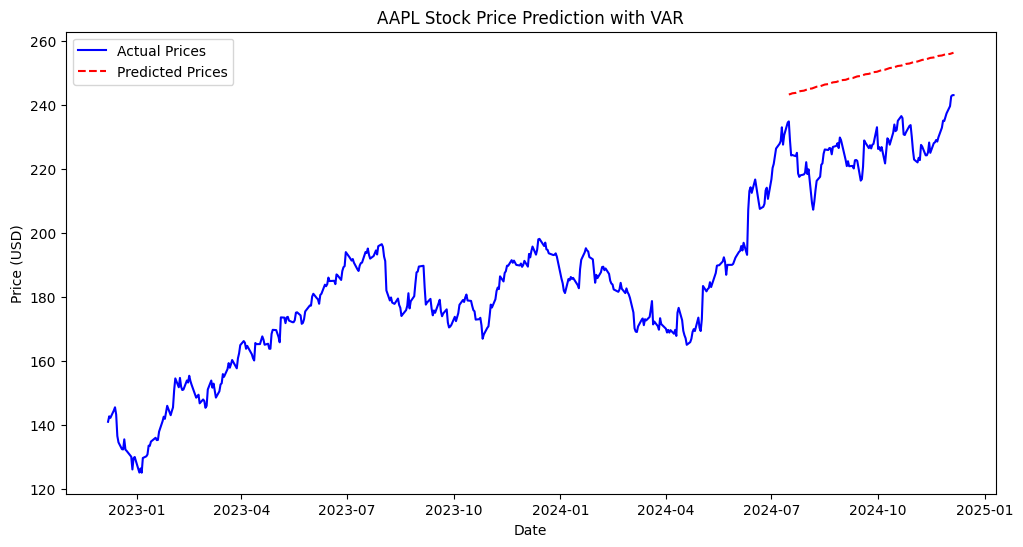

In [2]:
# Function to fetch stock data from Yahoo Finance
def get_data_from_yahoo(ticker, start_date, end_date):
    data = yf.download(ticker, start=start_date, end=end_date, interval="1d")
    return data

# Function to calculate MAE (Mean Absolute Error)
def mae(actual, predicted):
    return np.mean(np.abs(actual - predicted))

# Function to calculate MAPE (Mean Absolute Percentage Error)
def mape(actual, predicted):
    return np.mean(np.abs((actual - predicted) / actual)) * 100

# Function to calculate R-squared (R²)
def r2_score(actual, predicted):
    ss_total = np.sum((actual - np.mean(actual)) ** 2)
    ss_residual = np.sum((actual - predicted) ** 2)
    return 1 - (ss_residual / ss_total)

# User input for stock ticker and prediction date
ticker = input("Enter the stock ticker symbol (e.g., TSLA for Tesla): ")
prediction_date_input = input("Enter the prediction date (YY-MM-DD): ")

# Convert the prediction date to a datetime object by adding '20' to the year
try:
    prediction_date = datetime.strptime('20' + prediction_date_input, "%Y-%m-%d").date()
except ValueError:
    print("Invalid date format. Please use the format 'YY-MM-DD'.")
    prediction_date = None

if prediction_date:
    # Calculate the start date (2 years before the prediction date)
    start_date = prediction_date - timedelta(days=2 * 365)
    start_date_str = start_date.strftime("%Y-%m-%d")
    end_date_str = prediction_date.strftime("%Y-%m-%d")

    # Fetch stock data
    data = get_data_from_yahoo(ticker, start_date_str, end_date_str)

    # Check if data is sufficient
    if len(data) < 60:
        print("Not enough data available. At least 60 data points are required.")
    else:
        # Prepare the data
        data["Date"] = data.index
        data = data[["Date", "Close"]].dropna()

        # Simulate multivariate data for VAR by duplicating the "Close" column
        data["Close_2"] = data["Close"]  # Duplicate to create another "variable"

        # Train-test split for the data
        train_size = int(len(data) * 0.8)  # 80% for training, 20% for testing
        train_data = data[:train_size]
        test_data = data[train_size:]

        # Fit the VAR model
        model = VAR(train_data[["Close", "Close_2"]])  # Use both columns
        model_fitted = model.fit(5)  # Lag order of 5 days (you can adjust)

        # Forecast for the next period
        forecast = model_fitted.forecast(train_data[["Close", "Close_2"]].values[-5:], steps=1)

        # Display forecasted price
        forecast_value = forecast[0][0]  # Extract the predicted value from the forecast array
        print(f"Predicted stock price for {ticker} on {prediction_date.strftime('%Y-%m-%d')}: ${forecast_value:.2f}")

        # Evaluate the model performance
        test_predictions = model_fitted.forecast(test_data[["Close", "Close_2"]].values[-5:], steps=len(test_data))

        # Calculate RMSE
        rmse_value = rmse(test_data["Close"].values, test_predictions[:, 0])

        # If rmse_value is an array, take the first element
        if isinstance(rmse_value, np.ndarray):
            rmse_value = rmse_value[0]

        # Calculate MAE
        mae_value = mae(test_data["Close"].values, test_predictions[:, 0])

        # Calculate MAPE
        mape_value = mape(test_data["Close"].values, test_predictions[:, 0])

        # Calculate R-squared (R²)
        r2_value = r2_score(test_data["Close"].values, test_predictions[:, 0])

        # Display RMSE, MAE, MAPE, and R² in the subheader
        print(f"Root Mean Squared Error (RMSE): {rmse_value:.2f}")
        print(f"Mean Absolute Error (MAE): {mae_value:.2f}")
        print(f"Mean Absolute Percentage Error (MAPE): {mape_value:.2f}%")
        print(f"R-squared (R²): {r2_value:.2f}")

        # Plot the actual vs predicted prices
        plt.figure(figsize=(12, 6))
        plt.plot(data["Date"], data["Close"], label="Actual Prices", color="blue")
        plt.plot(test_data["Date"], test_predictions[:, 0], label="Predicted Prices", color="red", linestyle="--")
        plt.title(f"{ticker} Stock Price Prediction with VAR")
        plt.xlabel("Date")
        plt.ylabel("Price (USD)")
        plt.legend()
        plt.show()

else:
    print("Please enter a valid stock ticker symbol.")